> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset (No-show appointments)

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

## Introduction
This dataset collects information
from 100k medical appointments in vectoria
Brazil and is focused on the question
of whether or not patients show up
for their appointment or not. A number of
characteristics about the patient are
included. to check likli hood if this patient will show for his scheduled appointment or not?
● Patient ID is ID for every Patient
● Appointment ID is ID for Each appointment
● ‘ScheduledDay’ The day someone called or registered the appointment, this is before appointment of course.
● ‘Appointmentday’ tell us the date the patient should go to doctor
● ‘Neighborhood’ indicates the location of the hospital.
● Gender is Sex of each patient (M/F)
● Nieghborhood is location of each neiborhood hospital
● ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
● diabetes/Handcap/hypertension/alcholism: are true or false 
● SMS_recieved are whether patient recieved SMS or not.
● No show: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.


## Questions to be asked 
#### Q1- does the age of patient affect the liklihood of no show to appointments?
#### Q2- is there coorelation between gender and no show patients?
#### Q3- Do SMS reminders decrease the number of absences?
#### Q4- is thier coorelation between difference of schduled date and appointent date and No show?

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')


# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html


<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [3]:
df.shape

(110527, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
sum(df.duplicated())

0

In [6]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


#### mean of patient are 37 years
#### only 10% of data set have scholar ship medical
#### 20% of people has hipertension
#### 7% has diabetes
#### only 3% are alcholism

In [7]:
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

#### checking distribution of samples with Age below 1 year and all Samples VS No Show %

In [8]:
df[df['Age']<1]['No-show'].value_counts()

No     2901
Yes     639
Name: No-show, dtype: int64

In [9]:
df['No-show'].value_counts()

No     88208
Yes    22319
Name: No-show, dtype: int64

In [10]:
totalsamples = sum(df['No-show'].value_counts())
perct_of_noshow_categories = df['No-show'].value_counts()/totalsamples*100
perct_of_noshow_categories

No     79.806744
Yes    20.193256
Name: No-show, dtype: float64

In [11]:
samples_with_age_problem = sum(df[df['Age']<1]['No-show'].value_counts())
perct_of_noshow_categories_with_problems = df[df['Age']<1]['No-show'].value_counts()/samples_with_age_problem*100
perct_of_noshow_categories_with_problems



No     81.949153
Yes    18.050847
Name: No-show, dtype: float64

#### it seems that both samples of Age below 1 Year and above one year have same distribution againist Noshow 

In [12]:
df[df['Age']>100].nunique()

PatientId         4
AppointmentID     7
Gender            1
ScheduledDay      6
AppointmentDay    6
Age               2
Neighbourhood     4
Scholarship       1
Hipertension      2
Diabetes          1
Alcoholism        1
Handcap           2
SMS_received      2
No-show           2
dtype: int64

#### only 4 Patients are above 100 years

Text(0,0.5,' Handcap distribution')

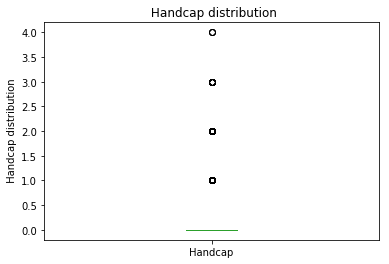

In [13]:
df['Handcap'].plot(kind='box')
plt.title(" Handcap distribution")
plt.ylabel(" Handcap distribution")

In [14]:
df['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

#### Hand Cap column has values above 1 while it should be binary (199 samples with values 2,3,4)

### Data Cleaning 

after checking our data we found below
#### 1) data has no Null values
#### 2) data has no dublicated rows
#### 3) scheduled day and Appointment Day are in string format and need to be changed to datetime format
#### 4) lets lowercase of all columns headers for easier use
#### 5) 1 case found with Age -1 should be exculuded and found 3539 cases with Age equals to zero i guess they are wrong too.i checked the percentage of no show in totalsamples and wrong samples and they are the same so removing them hopefully won't affect the distribution of samples.
#### 6) 7 appointments to four patients with age above 100 how ever i found this is normal in Brazil as per https://www.demogr.mpg.de/en/news_events_6123/news_press_releases_4630/press/the_oldest_old_substantially_fewer_centenarians_in_brazil_8149 so i will keep them

#### 7) appointment ID may change for same patient ID so its more convenient to keep appointment ID as row index
#### 8) handicap should be binary values however it has 5 unique values up to 4 and as per question in kaggle disscussion https://www.kaggle.com/joniarroba/noshowappointments/discussion/29699 any No# above 1 the Handcap has more handicaps than 1. will check later if this will affect the No show distribution 
#### 9) add to data column showing No of days between appointment and day patient called to schedule the appointment.

In [15]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null datetime64[ns]
AppointmentDay    110527 non-null datetime64[ns]
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: datetime64[ns](2), float64(1), int64(8), object(3)
memory usage: 11.8+ MB


In [17]:
df[df['No-show']=="Yes"].head()


,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
6,7.336882e+14,5630279,F,2016-04-27 15:05:12,2016-04-29,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27 15:39:58,2016-04-29,39,GOIABEIRAS,0,0,0,0,0,0,Yes
11,7.542951e+12,5620163,M,2016-04-26 08:44:12,2016-04-29,29,NOVA PALESTINA,0,0,0,0,0,1,Yes
17,1.479497e+13,5633460,F,2016-04-28 09:28:57,2016-04-29,40,CONQUISTA,1,0,0,0,0,0,Yes
20,6.222575e+14,5626083,F,2016-04-27 07:51:14,2016-04-29,30,NOVA PALESTINA,0,0,0,0,0,0,Yes


In [18]:
new_labels = []
for label in df.columns:
    new_labels.append(label.lower())
new_labels
df.columns=new_labels
new_labels

['patientid',
 'appointmentid',
 'gender',
 'scheduledday',
 'appointmentday',
 'age',
 'neighbourhood',
 'scholarship',
 'hipertension',
 'diabetes',
 'alcoholism',
 'handcap',
 'sms_received',
 'no-show']

In [19]:
#rename N0-show column to noshow
df.rename(columns={'no-show':'noshow'}, inplace=True)

In [20]:
df.set_index('appointmentid', inplace=True )

In [21]:
df.head()

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,noshow
appointmentid,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No
5642503,5.589978e+14,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No
5642549,4.262962e+12,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No
5642828,8.679512e+11,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
5642494,8.841186e+12,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [22]:
df_V1 = df[df['age']>1]

In [23]:
df_V1['scheduledday_date'] = df_V1['scheduledday'].dt.date

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [24]:
df_V1.shape

(104714, 14)

In [25]:
df_V1['appointmentday'] = df_V1['appointmentday'].dt.date
df_V1['appointmentday'] = pd.to_datetime(df_V1['appointmentday'])
df_V1['scheduledday_date'] = pd.to_datetime(df_V1['scheduledday_date'])
df_V1['date_dif'] = df_V1['appointmentday']- df_V1['scheduledday_date']
df_V1['date_dif'] = df_V1['date_dif']/np.timedelta64(1,'D')

df_V1['date_dif'] = df_V1['date_dif'].astype(int)
df_V1['noshow_b'] = df_V1['noshow'].map({'Yes': 1, 'No': 0})


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [26]:
df_V1.describe()

,patientid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,date_dif,noshow_b
count,1.047140e+05,104714.000000,104714.000000,104714.000000,104714.000000,104714.000000,104714.000000,104714.000000,104714.000000,104714.000000
mean,1.470482e+14,39.126096,0.102441,0.208196,0.075845,0.032087,0.023464,0.324875,10.198770,0.203077
std,2.556492e+14,22.018268,0.303229,0.406019,0.264751,0.176233,0.165824,0.468331,15.274631,0.402291
min,3.921784e+04,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.000000,0.000000
25%,4.164541e+12,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.163902e+13,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
75%,9.423332e+13,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,0.000000
max,9.999686e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000,1.000000


In [27]:
df_V1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104714 entries, 5642903 to 5629448
Data columns (total 16 columns):
patientid            104714 non-null float64
gender               104714 non-null object
scheduledday         104714 non-null datetime64[ns]
appointmentday       104714 non-null datetime64[ns]
age                  104714 non-null int64
neighbourhood        104714 non-null object
scholarship          104714 non-null int64
hipertension         104714 non-null int64
diabetes             104714 non-null int64
alcoholism           104714 non-null int64
handcap              104714 non-null int64
sms_received         104714 non-null int64
noshow               104714 non-null object
scheduledday_date    104714 non-null datetime64[ns]
date_dif             104714 non-null int64
noshow_b             104714 non-null int64
dtypes: datetime64[ns](3), float64(1), int64(9), object(3)
memory usage: 13.6+ MB


In [28]:
df_V1[df_V1['date_dif']<0]['date_dif'].count()

5

#### the % of patients that didn't show for appintment are 20%
#### average of difference between calling to schedule the appointment and appointment date is 10 days however median is 4 days
#### there is 5 samples with -ve values in difference between calling to schedule the appointment and appointment date (they called to schedule after appontment date) i will remove them

In [29]:
df_V1 = df_V1[df_V1['date_dif']>=0]

In [30]:
df_V1.describe()

,patientid,age,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,date_dif,noshow_b
count,1.047090e+05,104709.000000,104709.000000,104709.000000,104709.000000,104709.000000,104709.000000,104709.000000,104709.000000,104709.000000
mean,1.470453e+14,39.126369,0.102446,0.208206,0.075848,0.032089,0.023446,0.324891,10.199352,0.203039
std,2.556404e+14,22.018038,0.303235,0.406027,0.264757,0.176237,0.165773,0.468336,15.274757,0.402263
min,3.921784e+04,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.164541e+12,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.163982e+13,39.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000
75%,9.423372e+13,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,15.000000,0.000000
max,9.999686e+14,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,179.000000,1.000000


In [31]:
df_c = df_V1.copy()

In [32]:
df_c.to_csv('Noshow_cleaned.csv', index=False)

## Cleaning part actions

#### 1) data has no Null values
#### 2) data has no dublicated rows
#### 3) scheduled day and Appointment Day were in string format and changed to datetime format
#### 4) lowercase of all columns headers for easier use
#### 5) 1 case found with Age -1 should be exculuded and found 3539 cases with Age equals to zero i guess they are wrong too.i checked the percentage of no show in totalsamples and wrong samples and they are the same so removing them hopefully won't affect the distribution of samples.
#### 6) 7 appointments to four patients with age above 100 how ever i found this is normal in Brazil as per https://www.demogr.mpg.de/en/news_events_6123/news_press_releases_4630/press/the_oldest_old_substantially_fewer_centenarians_in_brazil_8149 so i will keep them

#### 7) appointment ID may change for same patient ID so its more convenient to keep appointment ID as row index
#### 8) handicap should be binary values however it has 5 unique values up to 4 and as per question in kaggle disscussion https://www.kaggle.com/joniarroba/noshowappointments/discussion/29699 any No# above 1 the Handcap has more handicaps than 1. will check later if this will affect the No show distribution 
#### 9) add to data column showing No of days between appointment and day patient called to schedule the appointment.
#### 10) add no show with binary format for representation in scatter_matrix
#### 11) 5 rows of data found with appintment date before scheduled date removed

<a id='eda'></a>
## Exploratory Data Analysis



### general exploration 

In [33]:
#pd.plotting.scatter_matrix(df_c,figsize=(15,15))

In [34]:
df_c.head()

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,noshow,scheduledday_date,date_dif,noshow_b
appointmentid,,,,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,0,0
5642503,5.589978e+14,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,0,0
5642549,4.262962e+12,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,0,0
5642828,8.679512e+11,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,0,0
5642494,8.841186e+12,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,0,0


In [35]:
def cat_rep(df,variable,kind,text,title,xlabel,ylabel,figsize=(10,6)):
    df[variable].value_counts().plot(kind=kind,title=title,figsize=figsize)
    print(text)
    print(df[variable].value_counts()/len(df)*100)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

percentage of males and females in dataset
F    65.9227
M    34.0773
Name: gender, dtype: float64


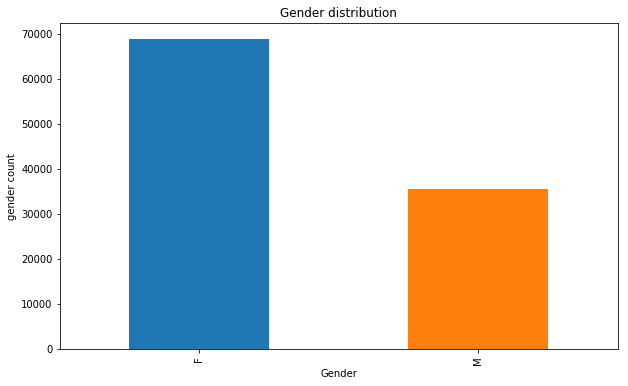

In [36]:

cat_rep(df_c,'gender','bar','percentage of males and females in dataset','Gender distribution','Gender','gender count')


#### Males are less than Females in this dataset

### check date columns

In [37]:
df_c[["scheduledday_date","appointmentday"]].describe()

,scheduledday_date,appointmentday
count,104709,104709
unique,110,27
top,2016-05-03 00:00:00,2016-06-06 00:00:00
freq,3988,4407
first,2015-11-10 00:00:00,2016-04-29 00:00:00
last,2016-06-08 00:00:00,2016-06-08 00:00:00


In [38]:
df_c['scheduledday_date'].value_counts().count()

110

Text(0,0.5,'Count of patients')

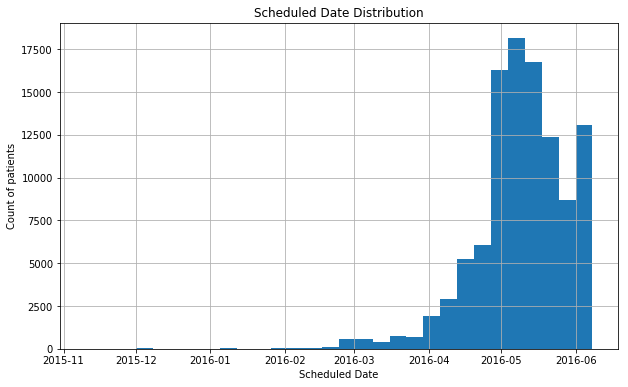

In [39]:
df_c['scheduledday_date'].hist(bins=30,figsize=(10,6))
plt.title('Scheduled Date Distribution')
plt.xlabel('Scheduled Date')
plt.ylabel('Count of patients')

Text(0,0.5,'Count of patients')

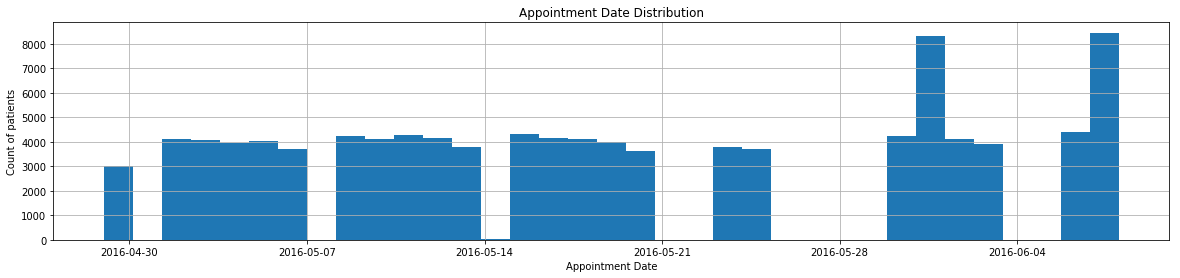

In [40]:
df_c['appointmentday'].hist(bins=35,figsize=(20,4))
plt.title('Appointment Date Distribution')
plt.xlabel('Appointment Date')
plt.ylabel('Count of patients')

#### there is gaps between appointment dates so it seems there is weekly off days or missing form dataset

In [41]:
df_1 = pd.DataFrame()
df_1['appointmentday'] = df_c['appointmentday'].dt.day_name()

Wednesday    24599
Tuesday      24350
Monday       21325
Friday       18073
Thursday     16323
Saturday        39
Name: appointmentday, dtype: int64

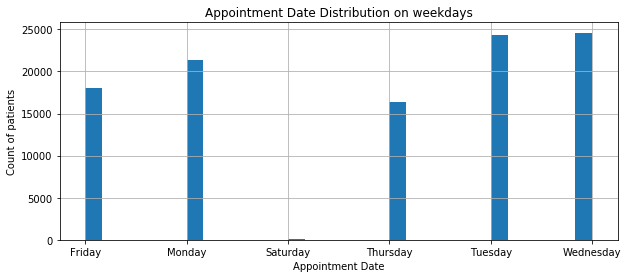

In [42]:
df_1['appointmentday'].hist(bins=30,figsize=(10,4))
plt.title('Appointment Date Distribution on weekdays')
plt.xlabel('Appointment Date')
plt.ylabel('Count of patients')
df_1['appointmentday'].value_counts()

### comments on dates
#### 1) appointment day has 27 unique values from 29-april-2016 to 8-june-2016
#### 2) scheduled date has 110 unique values starting from 10-Nov-2015 to 8-june-2016 and has time stamp
#### 3) it seems that there is 2 days off per week Sunday and Saturday as saterday has 39 patients with appointment only

count of nieghborhoods


81

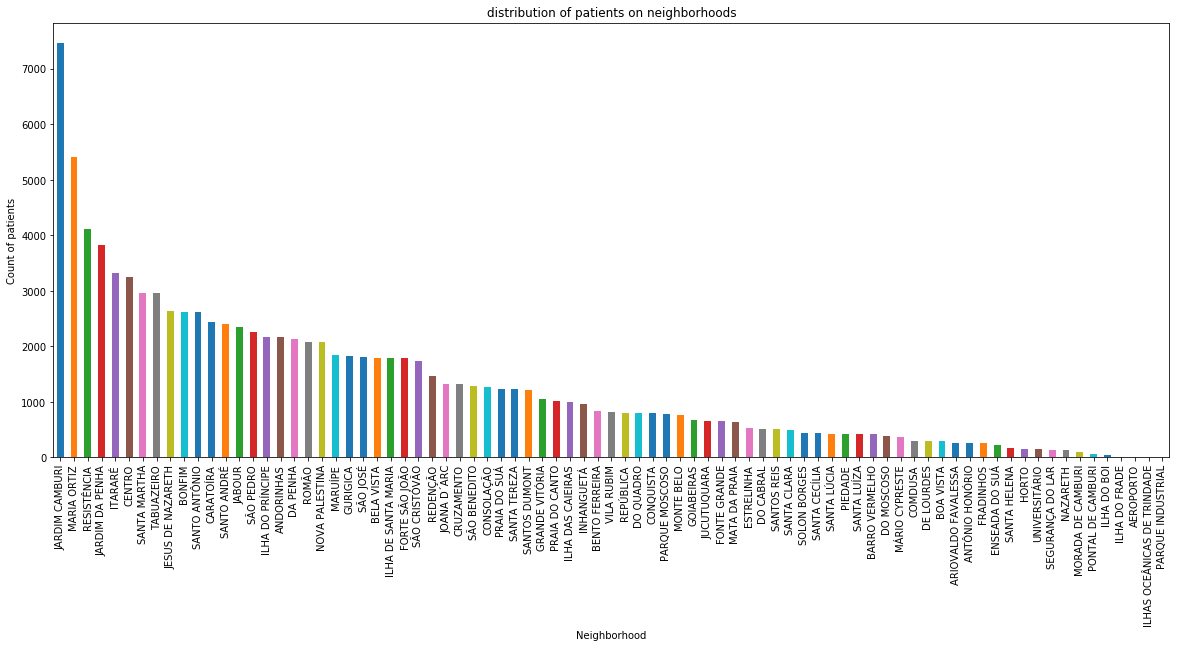

In [43]:
df_c['neighbourhood'].value_counts().plot(kind='bar',figsize=(20,8))
plt.title('distribution of patients on neighborhoods')
plt.xlabel('Neighborhood')
plt.ylabel('Count of patients')
print("count of nieghborhoods") 

df_c['neighbourhood'].value_counts().count()

#### we have 81 Nieghborhood 
#### most congested neighorhood is "JARDIM CAMBURI" and less one is "PARQUE INDUSTRIAL" 

percentage of scholarship in dataset
0    89.755417
1    10.244583
Name: scholarship, dtype: float64


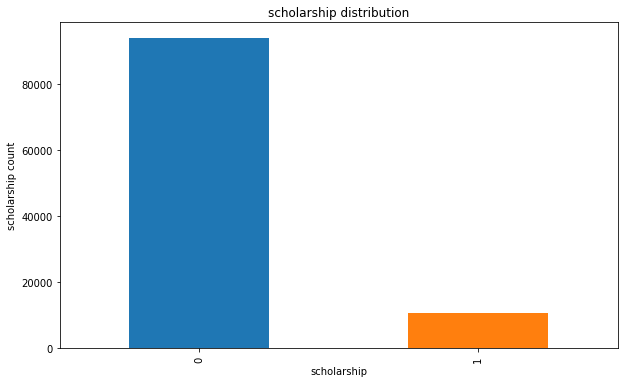

In [44]:


cat_rep(df_c,'scholarship','bar','percentage of scholarship in dataset','scholarship distribution','scholarship','scholarship count')


#### only small samples of Dataset has scholarship for medical (10% as mentioned before)

percentage of hipertension in dataset
0    79.17944
1    20.82056
Name: hipertension, dtype: float64


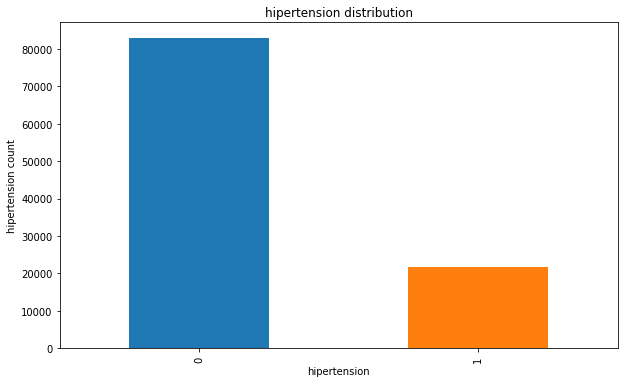

In [45]:

cat_rep(df_c,'hipertension','bar','percentage of hipertension in dataset','hipertension distribution','hipertension','hipertension count')



#### 20% of patient has hypertension

percentage of diabetes in dataset
0    92.41517
1     7.58483
Name: diabetes, dtype: float64


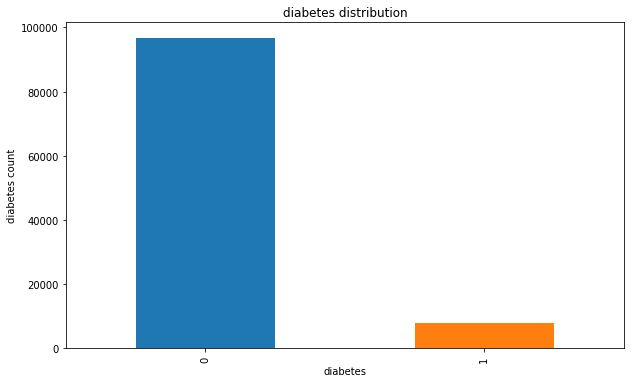

In [46]:

cat_rep(df_c,'diabetes','bar','percentage of diabetes in dataset','diabetes distribution','diabetes','diabetes count')


#### 7% of patient has diabetes

percentage of alcoholism in dataset
0    96.791107
1     3.208893
Name: alcoholism, dtype: float64


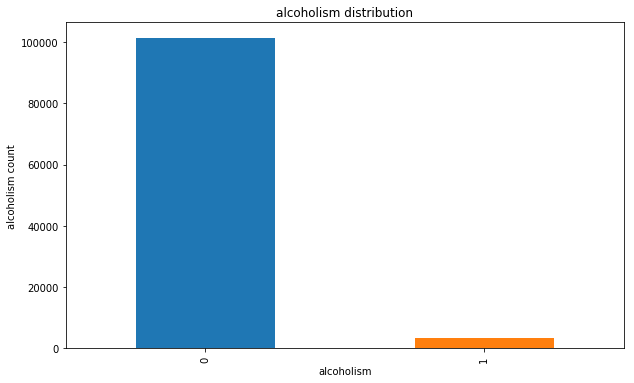

In [47]:
cat_rep(df_c,'alcoholism','bar','percentage of alcoholism in dataset','alcoholism distribution','alcoholism','alcoholism count')


#### 3% of patient are alcholism

percentage of handcap in dataset
0    97.863603
1     1.946347
2     0.174770
3     0.012415
4     0.002865
Name: handcap, dtype: float64


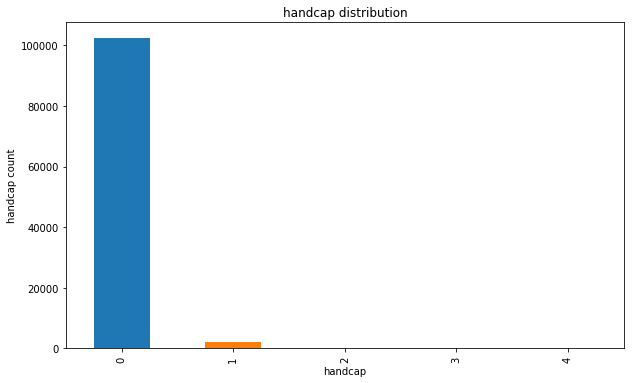

In [48]:
cat_rep(df_c,'handcap','bar','percentage of handcap in dataset','handcap distribution','handcap','handcap count')


#### 2% of patients are handcap

percentage of sms_received in dataset
0    67.510911
1    32.489089
Name: sms_received, dtype: float64


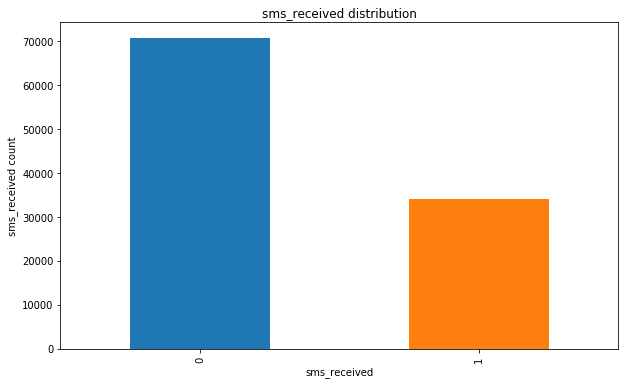

In [49]:

cat_rep(df_c,'sms_received','bar','percentage of sms_received in dataset','sms_received distribution','sms_received','sms_received count')


#### only 32% with SMS recieved

### general comments on dataset
#### 1) thier is 81 nieghborhood in dataset
#### 2) 10% of dataset with scholarship
#### 3) 20% of dataset with hipertension   
#### 4) 7.5% with daiabetes
#### 5) 3% arre alcholism
#### 6) 2% are handicap
#### 7) only 32% with SMS recieved
#### 8) dataset has more female samples(66%)

### comments on dates
#### 1) appointment day has 27 unique values from 29-april-2016 to 8-june-2016
#### 2) scheduled date has 110 unique values starting from 10-Nov-2015 to 8-june-2016 and has time stamp



### Research Question 1 (does the age of patient affect the liklihood of no show to appointments?)

split data based on No show columns to start seeing the data distribution

In [50]:
df_yes = df_c[df_c['noshow']=="Yes"]
df_no = df_c[df_c['noshow']=="No"]

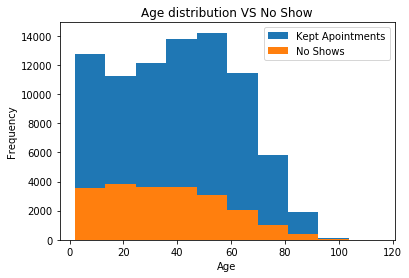

In [51]:
df_no['age'].plot.hist()
df_yes['age'].plot.hist()
plt.title('Age distribution VS No Show')
plt.legend(['Kept Apointments', 'No Shows'])
plt.xlabel('Age')
plt.show()

##### Age distribution is right skewed however this is normal as it starts with zero and decrease as no increases

mean of Age of people that didn't show for appointment
35.9997177799


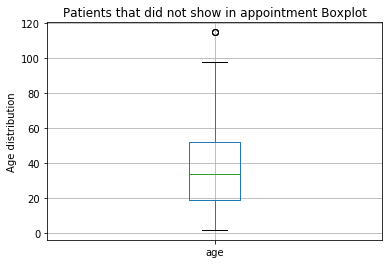

In [52]:
df_yes['age'].plot(kind='box',grid=1)
print("mean of Age of people that didn't show for appointment")
plt.title('Patients that did not show in appointment Boxplot')
plt.ylabel('Age distribution')
print(df_yes['age'].mean())

mean of Age of people that showed for appointment
39.9229349663


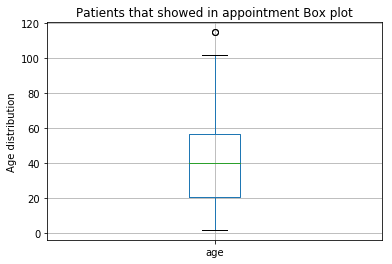

In [53]:
df_no['age'].plot(kind='box',grid=1)
print("mean of Age of people that showed for appointment")
plt.title('Patients that showed in appointment Box plot')
plt.ylabel('Age distribution')
print(df_no['age'].mean())

### answer to Q1
##### mean of age of people that didn't show for appointment are younger than showed people (older people stick more to thier appointments may be as they are affraid more of sickness)

### Research Question 2 (is there coorelation between gender and no show patients?)

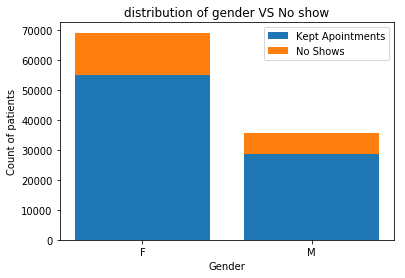

In [54]:
plt.bar(df_no['gender'].unique(),df_no['gender'].value_counts())
plt.bar(df_yes['gender'].unique(),df_yes['gender'].value_counts(),bottom=df_no['gender'].value_counts())
plt.legend(['Kept Apointments', 'No Shows'])
plt.title('distribution of gender VS No show')
plt.xlabel('Gender')
plt.ylabel('Count of patients')
plt.show()


#### Males are alot less than females and thier is no obvious No show biased to certain gender

In [55]:
gender_counts = df_c.groupby('gender')['noshow'].value_counts()
gender_counts

gender  noshow
F       No        54957
        Yes       14070
M       No        28492
        Yes        7190
Name: noshow, dtype: int64

In [56]:
print("females percentage that showed in appointment")
print(round(gender_counts[0]/(gender_counts[0]+gender_counts[1])*100,1))
print("males percentage that showed in appointment")
print(round(gender_counts[2]/(gender_counts[2]+gender_counts[3])*100,1))

females percentage that showed in appointment
79.6
males percentage that showed in appointment
79.8


### answer to Q2
percentage of males and females that didn't show for appointment are the same
so no specific coorelation between gender and No show 

### Research Question 3  (Do SMS reminders decrease the number of absences?)

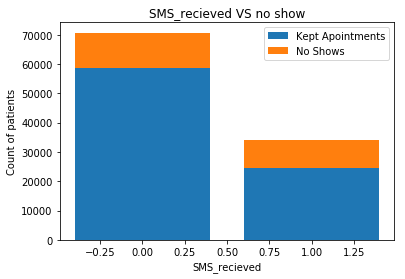

In [57]:
plt.bar(df_no['sms_received'].unique(),df_no['sms_received'].value_counts())
plt.bar(df_yes['sms_received'].unique(),df_yes['sms_received'].value_counts(),bottom=df_no['sms_received'].value_counts())
plt.legend(['Kept Apointments', 'No Shows'])
plt.title('SMS_recieved VS no show')
plt.xlabel('SMS_recieved')
plt.ylabel('Count of patients')
plt.show()

#### it seems that around 30% only of patient recieves SMS as reminder with the appointment 

In [58]:
sms_counts = df_c.groupby('sms_received')['noshow'].value_counts()
sms_counts

sms_received  noshow
0             No        58807
              Yes       11883
1             No        24642
              Yes        9377
Name: noshow, dtype: int64

In [59]:
print("percentage of people that showed in appointment and sms not recieved")
print(round(sms_counts[0][0]/(sms_counts[0][0]+sms_counts[0][1])*100,1))
print("percentage of people that showed in appointment and sms recieved")
print(round(sms_counts[1][0]/(sms_counts[1][0]+sms_counts[1][1])*100,1))

percentage of people that showed in appointment and sms not recieved
83.2
percentage of people that showed in appointment and sms recieved
72.4


### answer to Q3
percentage of patients that showed with out recieving SMS are larger than percentage of patients that recieved SMS so sending SMS with appointment doesn't increase patient that miss thier appointments


### Research Question 4 (is thier coorelation between difference of schduled date and appointent date and No show¶

In [60]:
df_c.head()

,patientid,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,noshow,scheduledday_date,date_dif,noshow_b
appointmentid,,,,,,,,,,,,,,,,
5642903,2.987250e+13,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016-04-29,0,0
5642503,5.589978e+14,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016-04-29,0,0
5642549,4.262962e+12,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016-04-29,0,0
5642828,8.679512e+11,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016-04-29,0,0
5642494,8.841186e+12,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016-04-29,0,0


In [ ]:
df_c.groupby('noshow')['date_dif'].plot(kind='hist',bins=40,figsize=(20,5))
plt.legend(['Kept Apointments', 'No Shows'])
plt.title('Days between Scheduled and appointment date VS no show')
plt.xlabel('Days between Scheduled and appointment date')
plt.ylabel('counts')
plt.show()

##### percentage of people that don't show in thier appointment are increases as difference between scedluing date and appointment date increases

In [ ]:
df_c.groupby('noshow')['date_dif'].value_counts().unstack().plot(kind="bar",stacked=True)
plt.title('Days between Scheduled and appointment date VS no show')
plt.ylabel('counts')
plt.show()

In [ ]:
print("percentage of patients that scheduled appointment with doctor on same day and showed on appointment is")
round(df_c[df_c['noshow']=="No"]['date_dif'].value_counts()[0]/df_c[df_c['date_dif']==0].count()[0]*100)

### answer to Q4
strong correlation found between percentage of patients that scheduled appointment with doctor on same day and showed on appointment (95%)

In [ ]:
df_c.corr()

### conclusions
1) mean of age of people that didn't show for appointment are younger than showed people (older people stick more to thier appointments may be as they are affraid more of sickness)
2) percentage of males and females that didn't show for appointment are the same so no specific coorelation between gender and No show
3) percentage of patients that showed with out recieving SMS are larger than percentage of patients that recieved SMS so sending SMS with appointment doesn't increase patient that miss thier appointments
4) strong correlation found between percentage of patients that scheduled appointment with doctor on same day and showed on appointment (95%)


# limitations
The Handcap column wasn't explained clearly on the dataset page as it as more than 2 values.
patients with 0 age are they wrong data?
distance between hospital and patient may have correlation with no show

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])